In [1]:
# Import all libraries

import netCDF4 as nc
import os
from netCDF4 import Dataset
import numpy as np
from pyschism.mesh import Hgrid
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from shapely.geometry import Polygon

In [2]:
# set the working directory
os.getcwd()
os.chdir('..')
workdir = os.getcwd()

# read the hgrid file
hgrid3_file = os.path.join(workdir, 'data/hgrid.gr3')
# hgridll_file = os.path.join(workdir, 'data/hgrid.ll')
# hgridwwm_file = os.path.join(workdir, 'data/hgrid_WWM.gr3')

# Read the nc files from different time (double check if the number here means different time step)
ncfile_marshflag_1 = os.path.join(workdir,'schout_1_marsh_flag.nc')
ncfile_marshflag_73 = os.path.join(workdir,'schout_73_marsh_flag.nc')

/Users/mirandalv/opt/anaconda3/envs/env_pyschism/lib/python3.8/site-packages/pyschism/mesh/parsers/grd.py:192: UserWarning: File /Users/mirandalv/Documents/projects/TMM/schism_test/data/hgrid.gr3 does not contain CRS information and no CRS was given.
  warnings.warn(f'File {str(resource)} does not contain CRS '


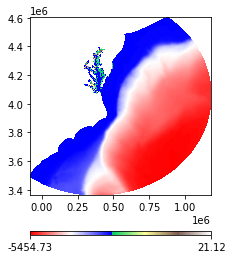

dict_keys(['description', 'nodes', 'elements', 'crs', 'boundaries'])

In [3]:
# Get the hgrid info

hgrid = Hgrid.open(hgrid3_file)
hgrid.make_plot(show=True)

#hgrid.write(os.path.join(workdir, 'output/file.2dm'), format='2dm')

hgrid_dict = hgrid.to_dict()
hgrid_dict.keys()

# elements: connectivity table: element #, element type (triangle or quad), nodes 1-4
# nodes: node id, x, y, depth
# boundaries: page 60 for details: http://ccrm.vims.edu/schismweb/SCHISM_v5.9-Manual.pdf

In [ ]:
hgrid_dict['nodes'] # the length of nodes is similar to the marsh_flag variable array in the .nc file
hgrid_dict['elements']
hgrid_dict['crs']
hgrid_dict['boundaries']

In [ ]:
# Read the output .nc files at two different time stamps
# These two files will be used to retrieve the marsh changes over time

ds_marshflag_1 = nc.Dataset(ncfile_marshflag_1)
ds_marshflag_73 = nc.Dataset(ncfile_marshflag_73)


# Get the marsh array

before_marsh = ds_marshflag_1.variables['marsh_flag'][:].data[0]
after_marsh = ds_marshflag_73.variables['marsh_flag'][:].data[0]

In [ ]:
ds_marshflag_1

In [ ]:
def get_marsh_change(x):
    
    if x['marsh_before'] > x['marsh_after']:
        return 'loss'
    elif x['marsh_before'] < x['marsh_after']:
        return 'gain'
    else:
        return 'no_change'


def retrieve_point(x, nodes):
    
    """
    This function can be used to convert a list of points (x,y) to connectivity vectors (lon, lat),
    But since the input .nc file is large, and the operation of converting to different crs takes longer time, 
    the crs convertion is not implemented. Keep this function for further usage.
    
    x: a data frame of merged output (with marsh changes)
    nodes: a dictionary saves all the nodes (x, y) from the .nc file
    
    y: ndarray
    """
    
    assert isinstance(nodes, dict)
    
    x1, y1 = to_latlon(nodes[str(x['node1'])][0])
    x2, y2 = to_latlon(nodes[str(x['node2'])][0])
    x3, y3 = to_latlon(nodes[str(x['node3'])][0])
    
    y = np.concatenate(([[x1, y1]],[[x2, y2]],[[x3, y3]]), axis=0)
    
    poly = Polygon(y)

    return poly


def point_to_poly(x):
    
    assert isinstance(x, (list,tuple,np.ndarray))
    
    poly = Polygon(x)
    
    return poly


def get_geom(x, nodes):
    
    """
    Read a list of numpy array from the hgrid['element'], retrieving the x,y of the corresponding nodes, and converting
    the nodes into geospatial polygons.
    
    x: a data frame of merged output (with marsh changes)
    nodes: a dictionary saves all the nodes (x, y) from the .nc file
    
    y: ndarray
    """
    
    assert isinstance(nodes, dict)
    
    x1, y1 = nodes[str(x['node1'])][0]
    x2, y2 = nodes[str(x['node2'])][0]
    x3, y3 = nodes[str(x['node3'])][0]
    
    y = np.concatenate(([[x1,y1]],[[x2,y2]],[[x3,y3]]), axis=0)
    
    poly = Polygon(y)

    return poly


# chesapeake bay utm zone 18s, espg: 32718 (double check where to read the correct crs of this .nc file)

def to_latlon(geom):
    
    """
    Convert a geometry point to WGS84
    """
    
    assert isinstance(geom, (list,tuple,np.ndarray))
    
    transformer = Transformer.from_crs("epsg:32718", "epsg:4326")
    
    x,y = transformer.transform(geom[0], geom[1])
    
    return x,y




In [ ]:
# convert the nodes to a geodataframe
df_nodes = pd.DataFrame.from_dict(hgrid_dict['nodes'], orient='index', columns=['geom', 'depth'])
df_ele = pd.DataFrame.from_dict(hgrid_dict['elements'], orient='index', columns=['node1', 'node2', 'node3'])

# add index to the output list (before)
df_before = pd.DataFrame(before_marsh, columns=['marsh_before'])
df_before['row_num'] = (np.arange(len(df_before)) + 1).astype(str)
df_before = df_before.set_index('row_num')

# add index to the output list (after)
df_after = pd.DataFrame(after_marsh, columns=['marsh_after'])
df_after['row_num'] = (np.arange(len(df_after)) + 1).astype(str)
df_after = df_after.set_index('row_num')


# merge the output with the connectivity table by index
df = pd.merge(df_ele, df_before, left_index=True, right_index=True)
df = pd.merge(df, df_after, left_index=True, right_index=True)


# Create a new column "marsh_change" indicating the change of marshes at two time stamps
df['marsh_change'] = df.apply(lambda x: get_marsh_change(x), axis=1)

# Retrieve the geometry of the hgrid['elements'] (connectivity table)
df['geom'] = df.apply(lambda x: get_geom(x, hgrid_dict['nodes']), axis=1)

# Creating a geodataframe
gdf = gpd.GeoDataFrame(df, geometry='geom')

In [ ]:
gdf = gdf.set_crs('epsg:26918')

In [ ]:
gdf.crs

In [ ]:
gdf.to_file('test_output.geojson', driver='GeoJSON')

In [ ]:
# testing

a = hgrid_dict['nodes']['1'][0]
b = hgrid_dict['nodes']['2'][0]
c = hgrid_dict['nodes']['3'][0]

y = np.concatenate(([a],[b],[c]), axis=0)

poly = point_to_poly(y)


In [ ]:
poly

In [ ]:
# Understand the data

# get the distribution of time step 1 marsh_flags

n, bins, patches = plt.hist(ds_marshflag_1.variables['marsh_flag'][:].data[0])
plt.show()


In [ ]:
# get the distribution of time step 1 marsh_flags


n, bins, patches = plt.hist(ds_marshflag_73.variables['marsh_flag'][:].data[0])
plt.show()

In [ ]:
np.count_nonzero(ds_marshflag_1.variables['marsh_flag'][:].data[0]==1)

In [ ]:
np.count_nonzero(ds_marshflag_73.variables['marsh_flag'][:].data[0]==1)

In [ ]:
# Accessing sediment

np.count_nonzero(ds_marshflag_1.variables['SED_TSC'][:].data[0]!=0)

In [ ]:
np. where(ds_marshflag_1.variables['SED_TSC'][:].data[0]!=0)

In [ ]:
ds_1 = nc.Dataset(os.path.join(workdir, "output_test/schout_1.nc"))
ds_73 = nc.Dataset(os.path.join(workdir, "output_test/schout_73.nc"))
ds_61 = nc.Dataset(os.path.join(workdir, "output_test/schout_61.nc"))

In [ ]:
ds_1.variables.keys()

In [ ]:
ds_1.variables['marsh_flag'][:].shape

In [ ]:
ds_1.variables['coordinate_system_flag'][0]